In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math, os
import glob
from sklearn.decomposition import PCA
# from sklearn.preprocessing import 
# from collections import defaultdict

In [6]:
def dataframe_of_CSI(directory):
    # Create empty DataFrames for walk, run, and jog
    df_walk = pd.DataFrame()
    df_run = pd.DataFrame()
    df_jog = pd.DataFrame()

    # Loop through each file in the directory
    for file in os.listdir(directory):
        # Check if the file is a CSV file and contains "walk", "run", or "jog" in the name
        if file.endswith(".csv") and ("walk" in file or "run" in file or "jog" in file):
            # Read the CSV file and extract the CSI_DATA column
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            print(df.columns)
            print(df.sig_mode.value_counts())
            csi_rows_raw = []

            ## Filtering can be done using
            df = df[(df["bandwidth"]==0)]# & (df["secondary_channel"]==1)]

            for one_row in df['CSI_DATA']:
                one_row = one_row.strip("[]")
                csi_row_raw = [int(x) for x in one_row.split(" ") if x != '']
                csi_rows_raw.append(csi_row_raw)
        
            # Convert the list of lists to a DataFrame and append it to the appropriate DataFrame based on the file name
            csi_df = pd.DataFrame(csi_rows_raw)

            # Check which dataframe we are working on and concat the data
            if "walk" in file:
                df_walk = pd.concat([df_walk, csi_df], axis=0)
            elif "run" in file:
                df_run = pd.concat([df_run, csi_df], axis=0)
            else:
                df_jog = pd.concat([df_jog, csi_df], axis=0)
    return df_walk, df_run, df_jog

In [7]:
# Define the directory path where the CSV files are located
directory = "C:\\Users\\Dell\\Documents\\Wifi-Sensing-HAR\\data\\our_data"

walk_df, run_df, jog_df = dataframe_of_CSI(directory)

Index(['type', 'role', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'bandwidth',
       'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi',
       'noise_floor', 'ampdu_cnt', 'channel', 'secondary_channel',
       'local_timestamp', 'ant', 'sig_len', 'rx_state', 'real_time_set',
       'real_timestamp', 'len', 'CSI_DATA'],
      dtype='object')
sig_mode
1    15088
0     6117
Name: count, dtype: int64
Index(['type', 'role', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'bandwidth',
       'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi',
       'noise_floor', 'ampdu_cnt', 'channel', 'secondary_channel',
       'local_timestamp', 'ant', 'sig_len', 'rx_state', 'real_time_set',
       'real_timestamp', 'len', 'CSI_DATA'],
      dtype='object')
sig_mode
1    29234
0    10547
Name: count, dtype: int64
Index(['type', 'role', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'bandwidth',
       'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi'

In [8]:
print(len(walk_df),len(run_df),len(jog_df))

29333 0 63175


In [9]:
## Extract Amplitude and Phase from the dataframe
def convert_csi_to_amplitude_phase(df):
    total_amplitudes = []
    total_phases = []

    for i, value in enumerate(df.values):
        imaginary = []
        real = []
        amplitudes = [] 
        phases = []

        csi_one_row_lst = value.tolist()

         # Create list of imaginary and real numbers from CSI
        [imaginary.append(csi_one_row_lst[item]) if item%2==0 else real.append(csi_one_row_lst[item]) for item in range(len(csi_one_row_lst))]

        # Transform imaginary and real into amplitude and phase
        val = int(len(csi_one_row_lst)//2)
        for k in range(val):
            amplitudes.append(round(math.sqrt(float(imaginary[k])** 2 + float(real[k])** 2),4))
            phases.append(round(math.atan2(float(imaginary[k]), float(real[k])),4))
        total_amplitudes.append(np.array(amplitudes))
        total_phases.append(np.array(phases))
    
    total_amplitudes_df = pd.DataFrame(total_amplitudes)
    total_phases_df = pd.DataFrame(total_phases)

        
    return total_amplitudes_df, total_phases_df

#### Amplitude and Phase of Walking

In [10]:
## Extract walk amplitude and phase
walk_amplitudes_df, walk_phases_df = convert_csi_to_amplitude_phase(walk_df)

## Here, based on sig_mode, 802.11a/g/n received. Here we receive both 802.11a/g and 802.11n
## So, either 52 or 56 total sub-carrier would be useful. The first 4 and the last 4 are rejected as null guard.


## Amplitude
walk_df1_amps = walk_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
walk_df2_amps = walk_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

walk_df_amps_final = pd.concat([walk_df1_amps, walk_df2_amps],axis=1)


## Phase
walk_df1_phase = walk_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
walk_df2_phase = walk_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

walk_df_phase_final = pd.concat([walk_df1_phase, walk_df2_phase],axis=1)

### Amplitude and Phase of Jogging

In [11]:
## Extract jog amplitude and phase
jog_amplitudes_df, jog_phases_df = convert_csi_to_amplitude_phase(jog_df)

## Amplitude
jog_df1_amps = jog_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
jog_df2_amps = jog_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

jog_df_amps_final = pd.concat([jog_df1_amps, jog_df2_amps],axis=1)


## Phase
jog_df1_phase = jog_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
jog_df2_phase = jog_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

jog_df_phase_final = pd.concat([jog_df1_phase, jog_df2_phase],axis=1)

#### Moving Average of the data

In [12]:
# Moving average of the data
def moving_average(df, window_size):
    """"
    Compute the moving average with a window of size specified
    """

    rolling_mean = df.rolling(window=window_size).mean()
    downsampled = rolling_mean.iloc[window_size::window_size, :]
    return downsampled


## Set moving average window of desired size 
window_size = 50
mov_avg_walk_amps_df = moving_average(walk_df_amps_final,window_size)
mov_avg_walk_phase_df = moving_average(walk_df_phase_final,window_size)
mov_avg_jog_amps_df = moving_average(jog_df_amps_final,window_size)
mov_avg_jog_phase_df = moving_average(jog_df_phase_final,window_size)

### Scaling of the dataframe

In [21]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_data = scaler.transform(df)
    return scaled_data

## PCA for Visualization

Here we have 52 to 54 usable columns. Not all columns/subcarriers are useful. So, we need to select only the useful ones. This can be done by PCA.

### PCA with arbitary n_components

In [156]:
def perform_pca(X, n_components):
    """
    Perform PCA on the data.
    """
    pca = PCA(n_components=n_components)
    pca.fit(X)
    new_sample = pca.transform(X)
    return pca, new_sample

### Plot the raw samples without PCA

In [17]:
## Select and plot raw scaled samples
def raw_sample_plot(downsampled):
    raw_sample =  pd.DataFrame(np.vstack(downsampled))

    fig1 = plt.figure(figsize = (18,20))

    ax1 = plt.subplot(611)
    # plt.plot(raw_sample.iloc[:,0],'r')
    # plt.plot(raw_sample.iloc[:,1],'g')
    # plt.plot(raw_sample.iloc[:,2],'b')
    # plt.plot(raw_sample.iloc[:,3],'cyan')
    # plt.plot(raw_sample.iloc[:,4],'brown')
    ax1.set_title("Signal Value 1 to 5 subcarrier")

    ax2 = plt.subplot(612)
    # plt.plot(raw_sample.iloc[:,5],'r')
    plt.plot(raw_sample.iloc[:,6],'g')
    plt.plot(raw_sample.iloc[:,7],'b')
    plt.plot(raw_sample.iloc[:,8],'cyan')
    plt.plot(raw_sample.iloc[:,9],'brown')
    ax2.set_title("Signal Value 6 to 10 subcarrier")

    ax3 = plt.subplot(613)
    plt.plot(raw_sample.iloc[:,10],'r')
    plt.plot(raw_sample.iloc[:,11],'g')
    plt.plot(raw_sample.iloc[:,12],'b')
    plt.plot(raw_sample.iloc[:,13],'cyan')
    plt.plot(raw_sample.iloc[:,14],'brown')
    ax3.set_title("Signal Value 11 to 15 subcarrier")

    ax4 = plt.subplot(614)
    plt.plot(raw_sample.iloc[:,15],'r')
    plt.plot(raw_sample.iloc[:,16],'g')
    plt.plot(raw_sample.iloc[:,17],'b')
    plt.plot(raw_sample.iloc[:,18],'cyan')
    plt.plot(raw_sample.iloc[:,19],'brown')
    ax4.set_title("Signal Value 16 to 20 subcarrier")

    ax5 = plt.subplot(615)
    plt.plot(raw_sample.iloc[:,20],'r')
    plt.plot(raw_sample.iloc[:,21],'g')
    plt.plot(raw_sample.iloc[:,22],'b')
    plt.plot(raw_sample.iloc[:,23],'cyan')
    plt.plot(raw_sample.iloc[:,24],'brown')
    ax5.set_title("Signal Value 21 to 25 subcarrier")

    ax6 = plt.subplot(616)
    plt.plot(raw_sample.iloc[:,25],'r')
    plt.plot(raw_sample.iloc[:,26],'g')
    plt.plot(raw_sample.iloc[:,27],'b')
    plt.plot(raw_sample.iloc[:,28],'cyan')
    plt.plot(raw_sample.iloc[:,29],'brown')
    ax6.set_title("Signal Value 25 to 30 subcarrier")
    plt.show()

In [18]:
mov_avg_walk_amps_df

,6,7,8,9,10,11,12,13,14,15,...,49,50,51,52,53,54,55,56,57,58
50,20.079782,21.470924,22.037658,22.103784,21.336608,21.736698,20.884620,20.354742,20.783506,19.405976,...,18.862634,18.886820,19.156880,18.553060,18.365306,18.132474,17.762702,19.128740,18.401956,19.086628
100,20.312104,21.610642,20.944364,21.799868,20.896630,22.125614,20.841760,20.230234,20.384884,19.662882,...,18.030616,19.205930,18.299156,17.744454,18.295210,17.888768,18.349876,19.021848,17.532108,18.024198
150,21.287142,21.251070,20.785030,22.508594,20.843646,21.611726,21.382298,20.844460,21.539360,19.813116,...,18.677712,19.135086,18.638558,18.033750,19.177036,18.533072,18.370196,19.900834,17.978238,19.043670
200,20.175880,20.638642,20.420328,20.634176,19.919592,20.586394,20.678606,19.285796,20.297050,19.768504,...,18.675662,18.831656,18.452054,18.039938,18.235476,17.921830,18.397432,19.555840,18.247416,18.652662
250,15.199660,15.572096,15.758530,16.311678,14.723440,16.284406,15.783176,16.240106,16.423350,15.075568,...,15.724876,15.746562,15.476746,15.321362,15.708364,16.013048,15.523362,17.119262,15.717440,15.294026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29100,18.305912,17.745684,18.146400,19.156054,18.217934,18.568254,18.577902,18.427862,18.106772,17.926426,...,17.285412,17.530848,17.086060,16.418132,16.694260,17.278274,16.296210,17.514318,17.263866,17.138280
29150,17.086294,17.804374,18.295358,18.407428,17.650408,18.329726,18.198090,17.806362,17.774492,17.119502,...,16.322868,16.853386,16.847980,16.887070,16.987054,16.925220,16.077696,16.994306,16.162016,16.539938
29200,19.620408,19.912606,20.433916,20.423218,20.266472,20.349306,20.272710,19.579406,19.775902,18.808124,...,19.469086,19.064650,18.752106,18.343498,19.022800,19.043848,18.979352,19.671716,19.280674,19.205778
29250,14.404900,15.248616,16.117228,16.176010,15.202784,16.104598,15.607306,14.483394,13.932694,16.119804,...,14.429210,15.502380,16.085164,15.421530,16.045238,15.845706,14.907800,17.019742,15.655432,16.211174


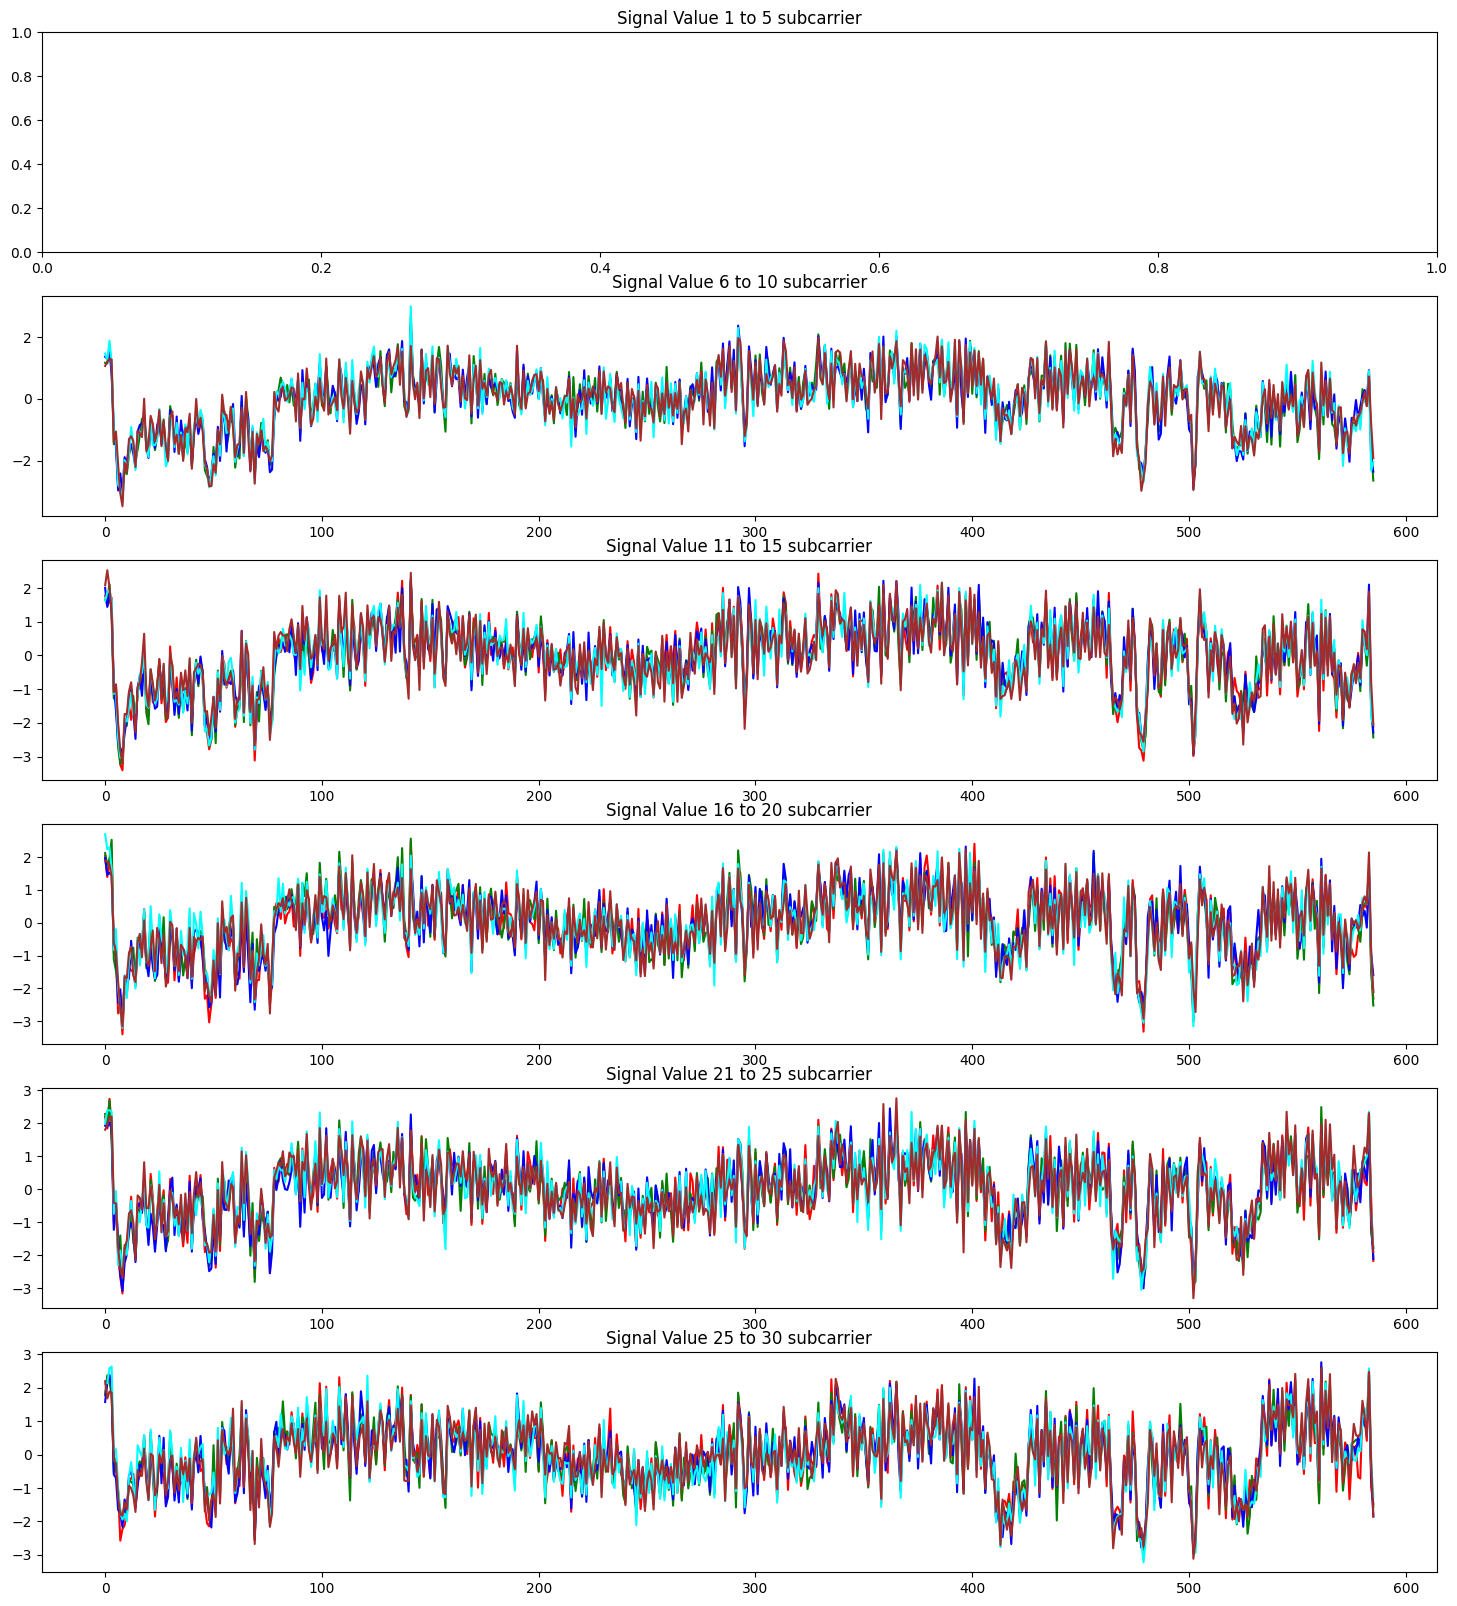

In [23]:
### Plot of amplitude of walking 400:500 i.e 1000 samples technically due to window_size
scaled_walk_amps_df = perform_scaling(mov_avg_walk_amps_df)
raw_sample_plot(scaled_walk_amps_df)
# raw_sample_plot(mov_avg_walk_amps_df)

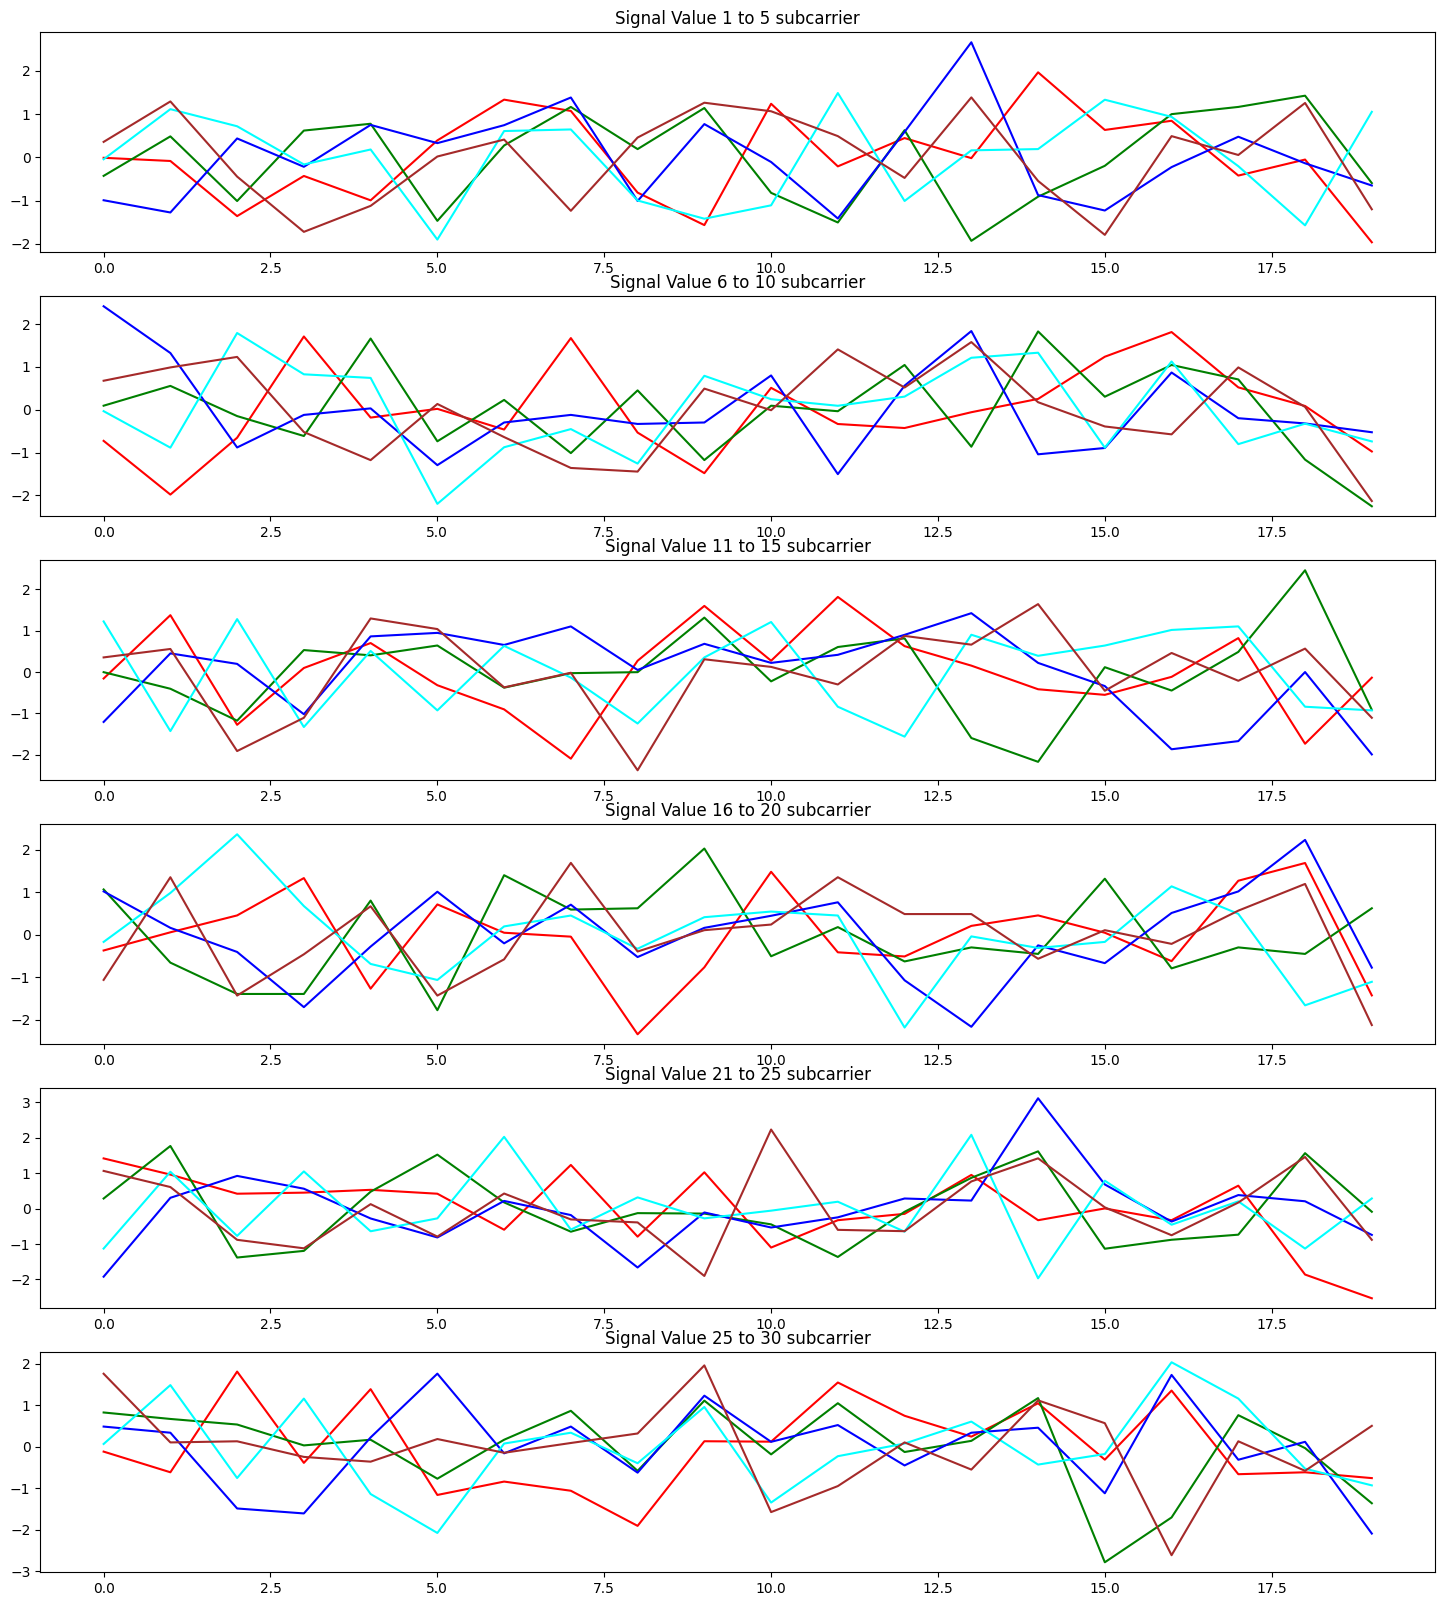

In [159]:
## Plot of amplitude of walking 400:500 i.e 1000 samples technically due to window_size
scaled_jog_amps_df = perform_scaling(mov_avg_jog_amps_df[200:220])
raw_sample_plot(scaled_jog_amps_df)

We can change the moving average window and also select larger interval.

### Plot data with PCA

In [124]:
## Select and plot pca scaled samples
def pca_visualization(new_sample):
    plt.figure(figsize = (18,20))

    ax1 = plt.subplot(611)
    plt.plot(new_sample[:,0])
    ax1.set_title("PCA 1st component")

    ax2 = plt.subplot(612)
    plt.plot(new_sample[:,1])
    ax2.set_title("PCA 2nd component")

    ax3 = plt.subplot(613)
    plt.plot(new_sample[:,2])
    ax3.set_title("PCA 3rd component")

    ax4 = plt.subplot(614)
    plt.plot(new_sample[:,3])
    ax4.set_title("PCA 4th component")

    ax5 = plt.subplot(615)
    plt.plot(new_sample[:,4])
    ax5.set_title("PCA 5th component")
    plt.show()

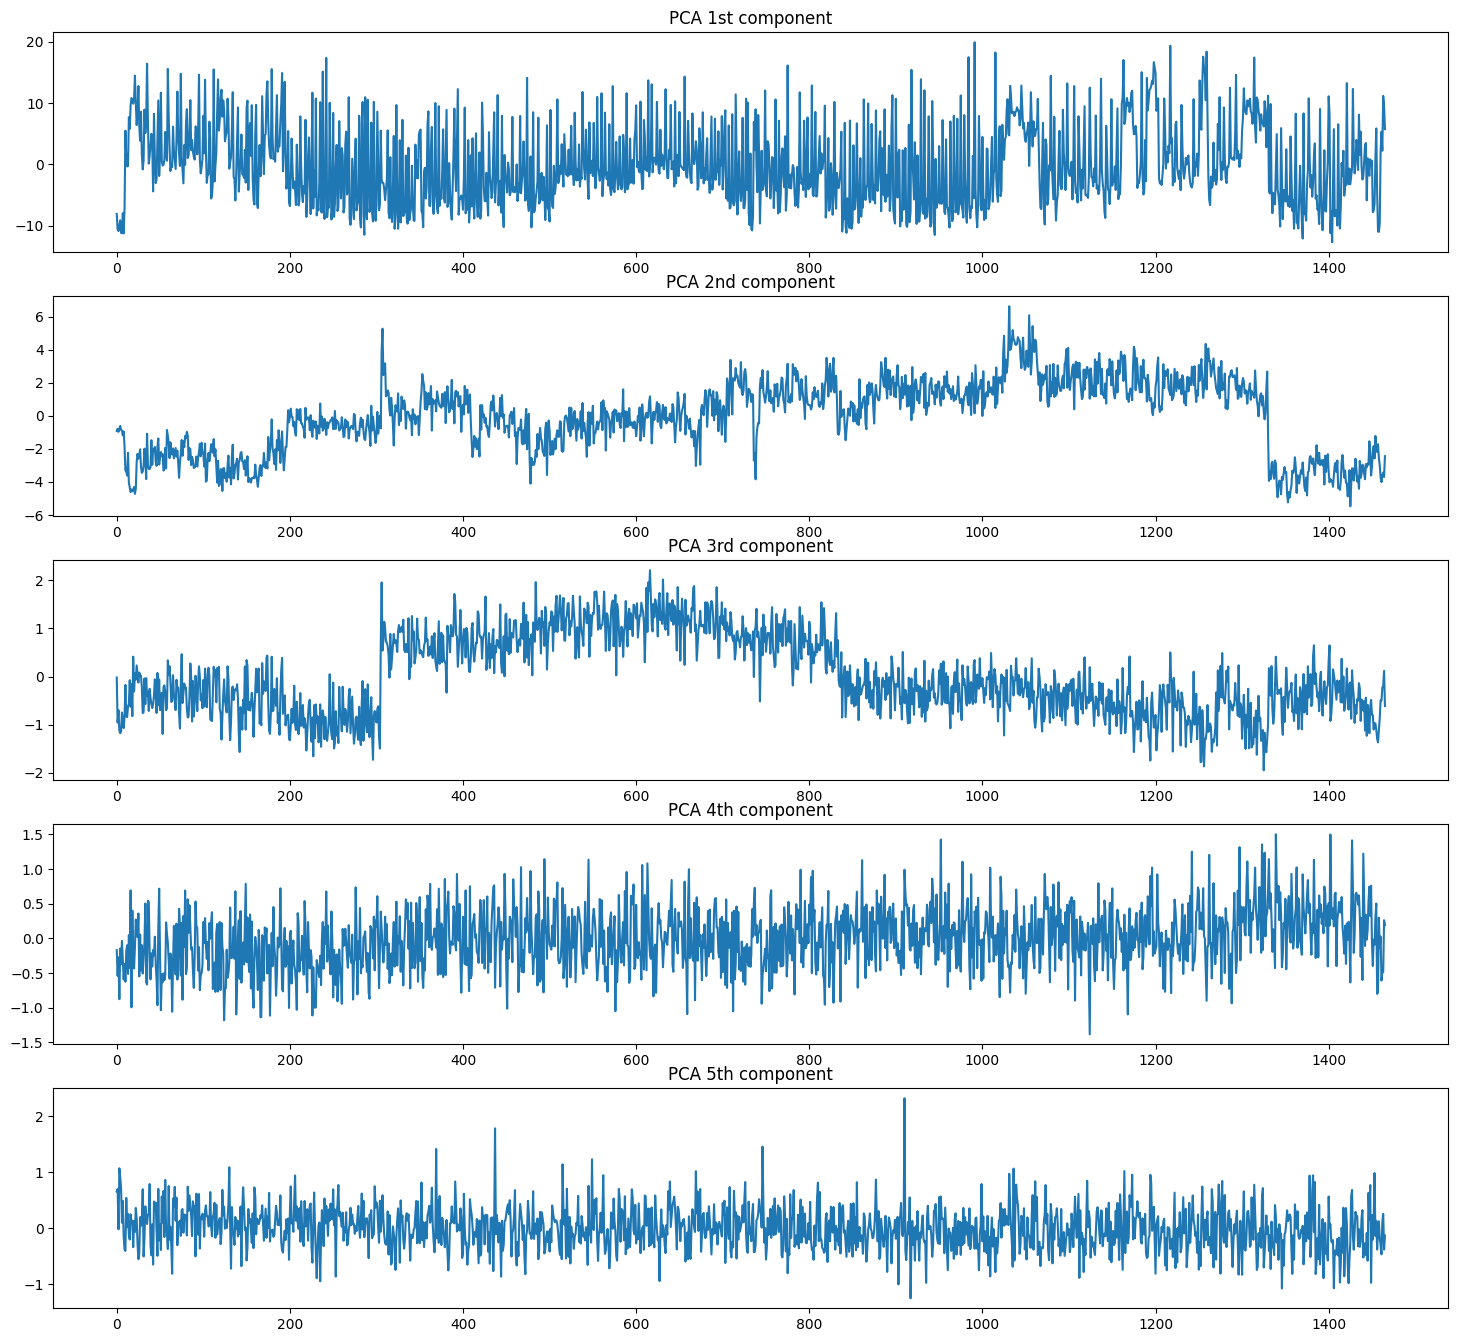

In [125]:
scaled_walk_amps_df = perform_scaling(mov_avg_walk_amps_df)
pca_obj, pca_walk_amps_df = perform_pca(scaled_walk_amps_df,n_components=5)
pca_visualization(pca_walk_amps_df)

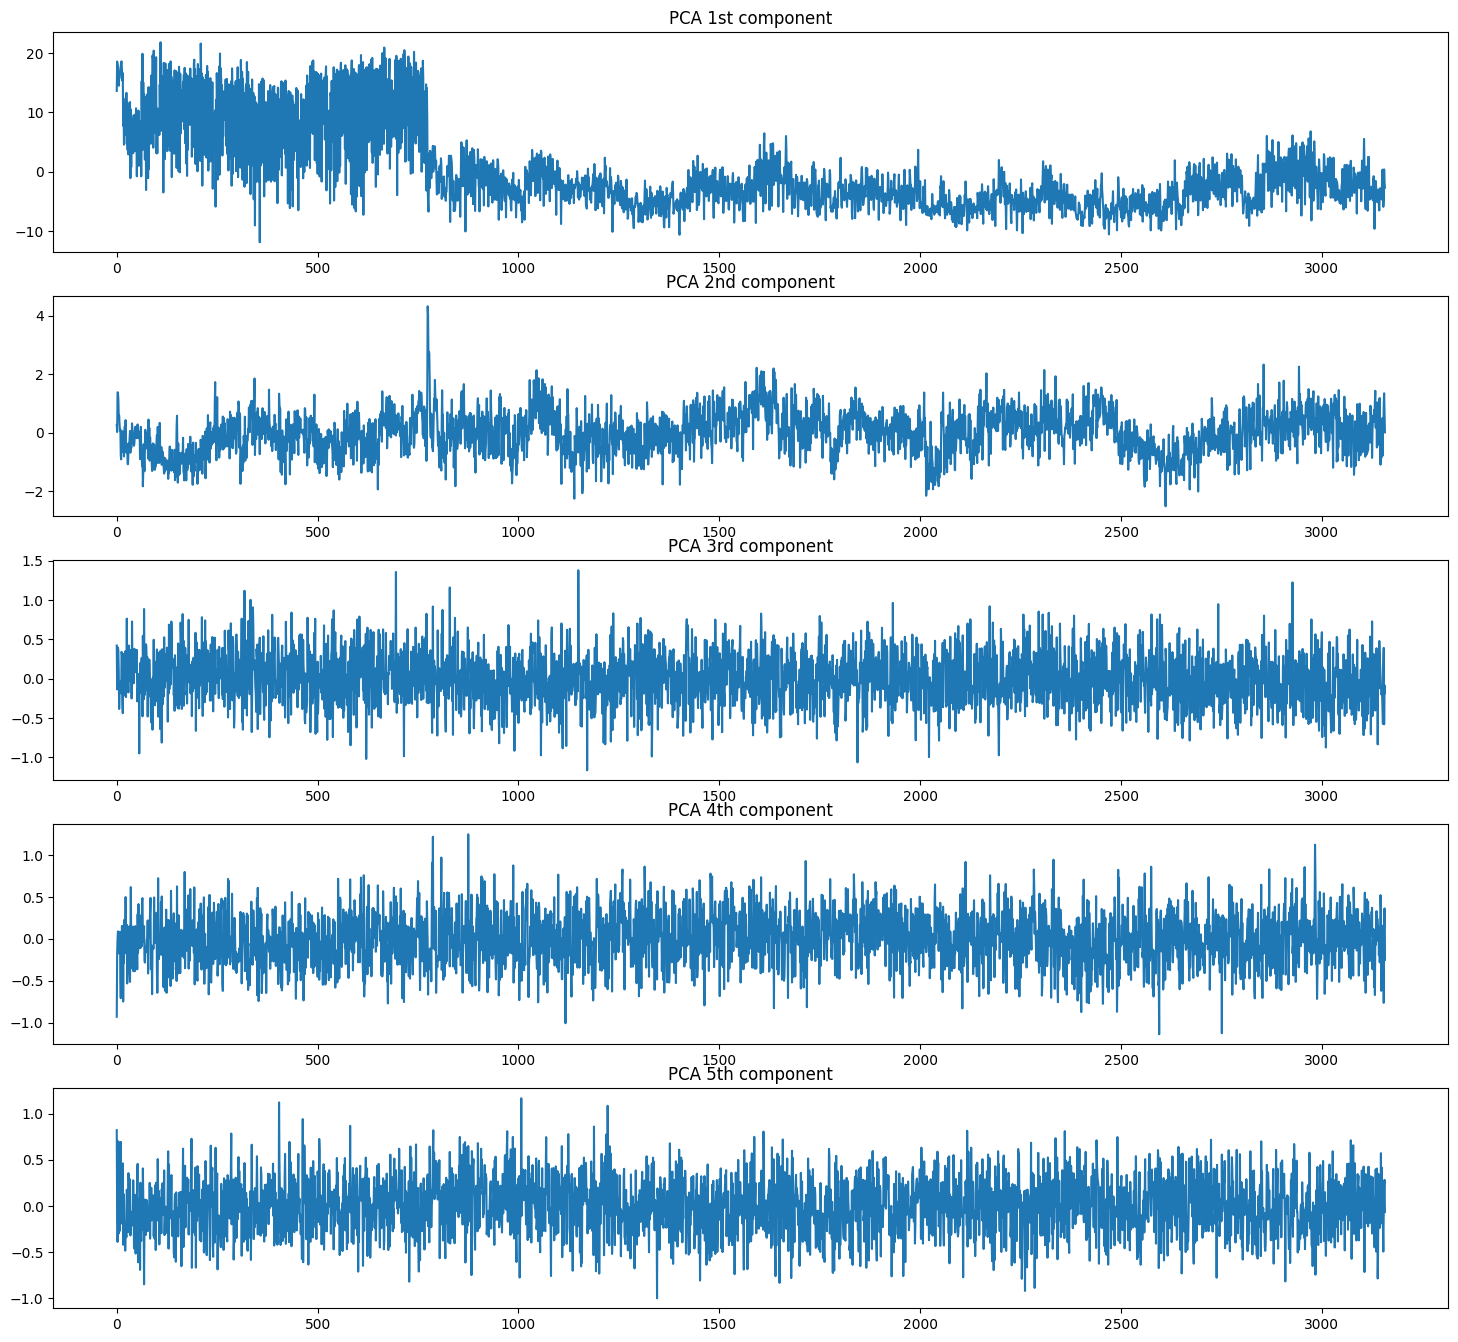

In [126]:
scaled_jog_amps_df = perform_scaling(mov_avg_jog_amps_df)
pca_obj, pca_jog_amps_df = perform_pca(scaled_jog_amps_df,n_components=5)
pca_visualization(pca_jog_amps_df)

### Frequency Domain Analysis Plots

In [127]:
# Define the directory path where the CSV files are located
directory = "C:\\Users\\Dell\\Documents\\Wifi-Sensing-HAR\\data\\processed_data\\after_FFT"

walk_fft_data = pd.read_csv(f"{directory}\\walk_merged_clean_fft.csv")
jog_fft_data = pd.read_csv(f"{directory}\\jog_merged_clean_fft.csv")
up_fft_data = pd.read_csv(f"{directory}\\up_merged_clean_fft.csv")

In [160]:
## Amplitude
def split_df(dataframe):
    csi_rows_raw = []

    for one_row in dataframe['CSI_AMP']:
        one_row = one_row.strip("[]")
        csi_row_raw = [float(x) for x in one_row.split(" ") if x != '']
        csi_rows_raw.append(csi_row_raw)
    splitted_df = pd.DataFrame(csi_rows_raw)

    return splitted_df



walk_fft1_amps = split_df(walk_fft_data).iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
walk_fft2_amps = split_df(walk_fft_data).iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

walk_fft_amps_final = pd.concat([walk_fft1_amps, walk_fft2_amps],axis=1)



jog_fft1_amps = split_df(jog_fft_data).iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
jog_fft2_amps = split_df(jog_fft_data).iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

jog_fft_amps_final = pd.concat([jog_fft1_amps, jog_fft2_amps],axis=1)



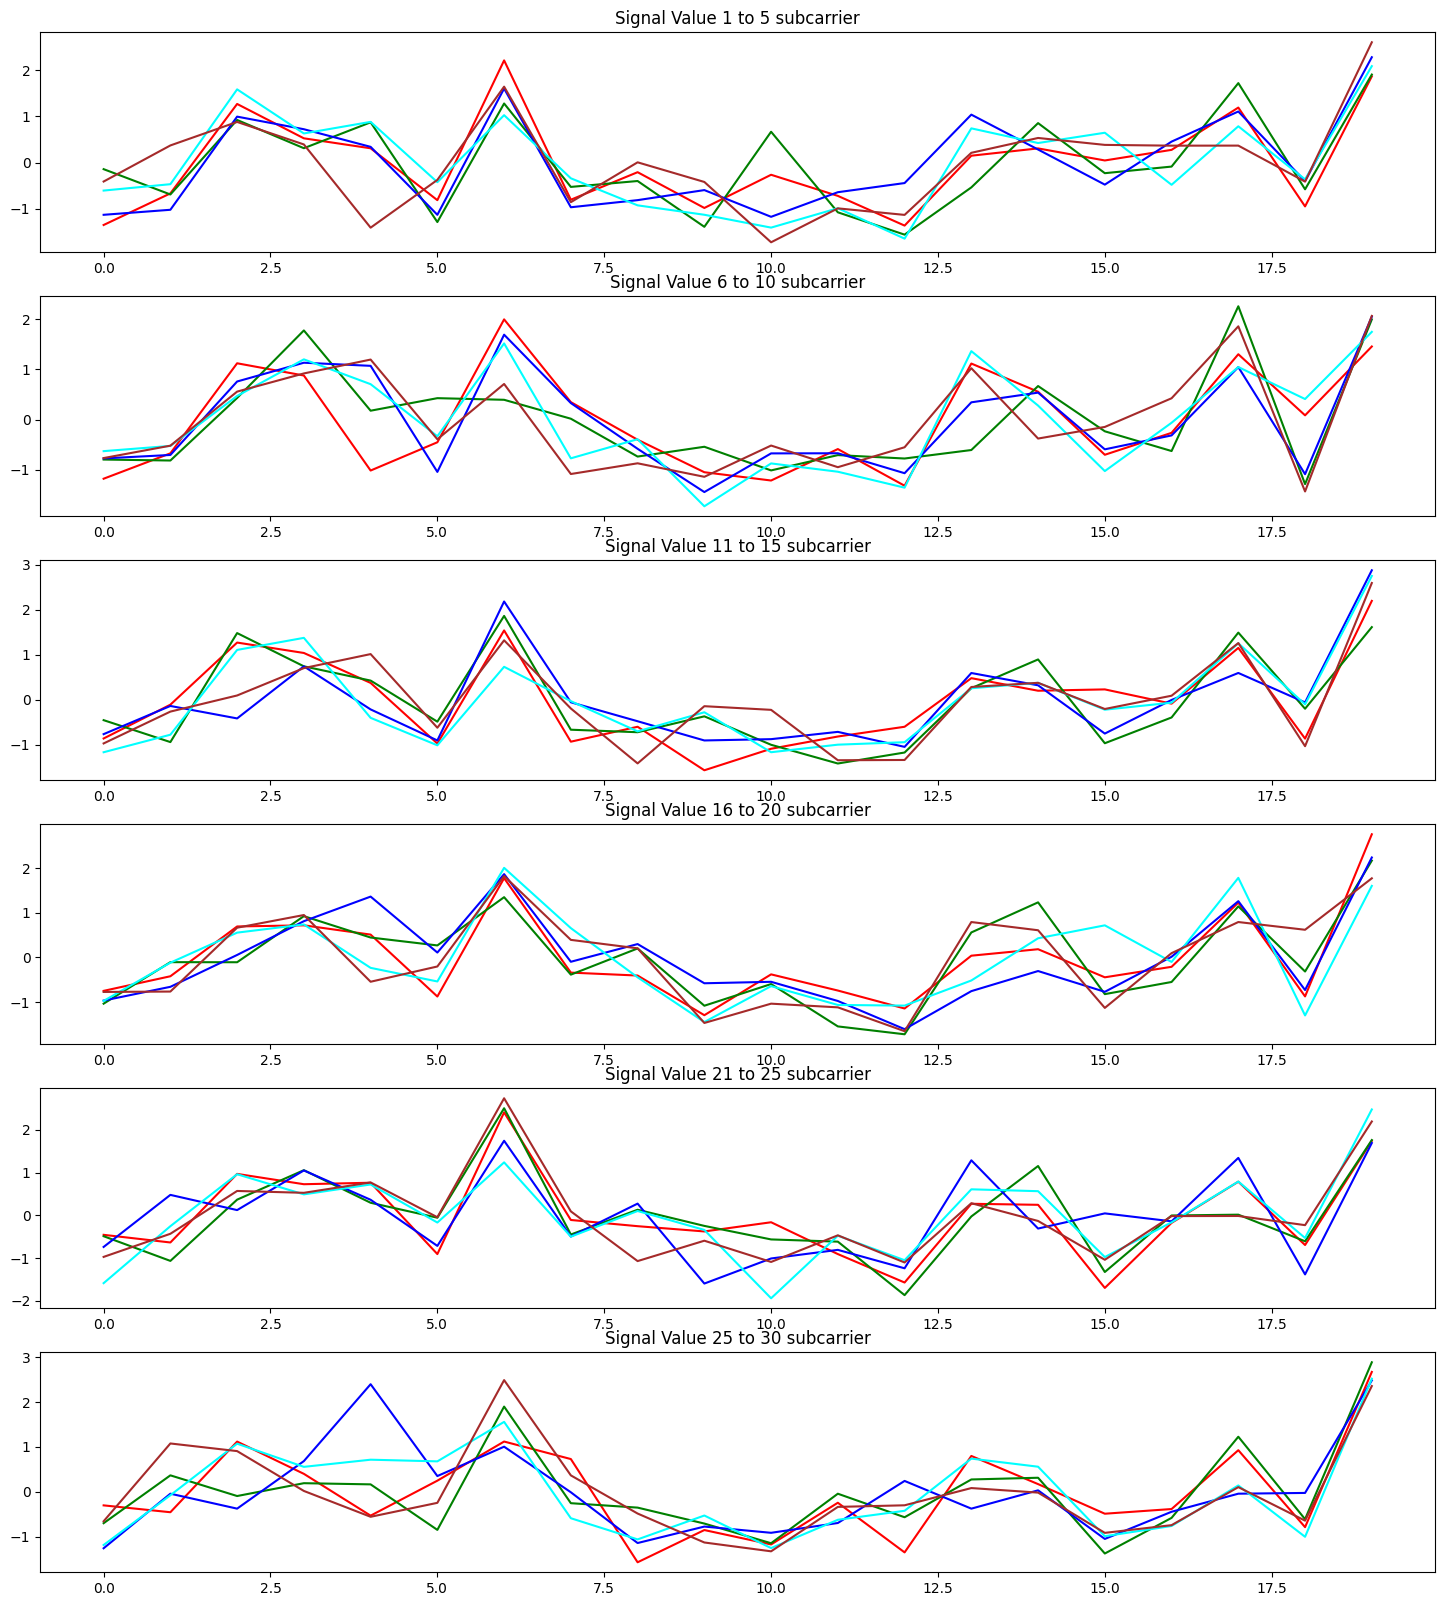

In [161]:
## Plot of amplitude of walking 400:500 i.e 1000 samples technically due to window_size
scaled_walk_fft_amps_df = perform_scaling(walk_fft_amps_final[200:220])
raw_sample_plot(scaled_walk_fft_amps_df)

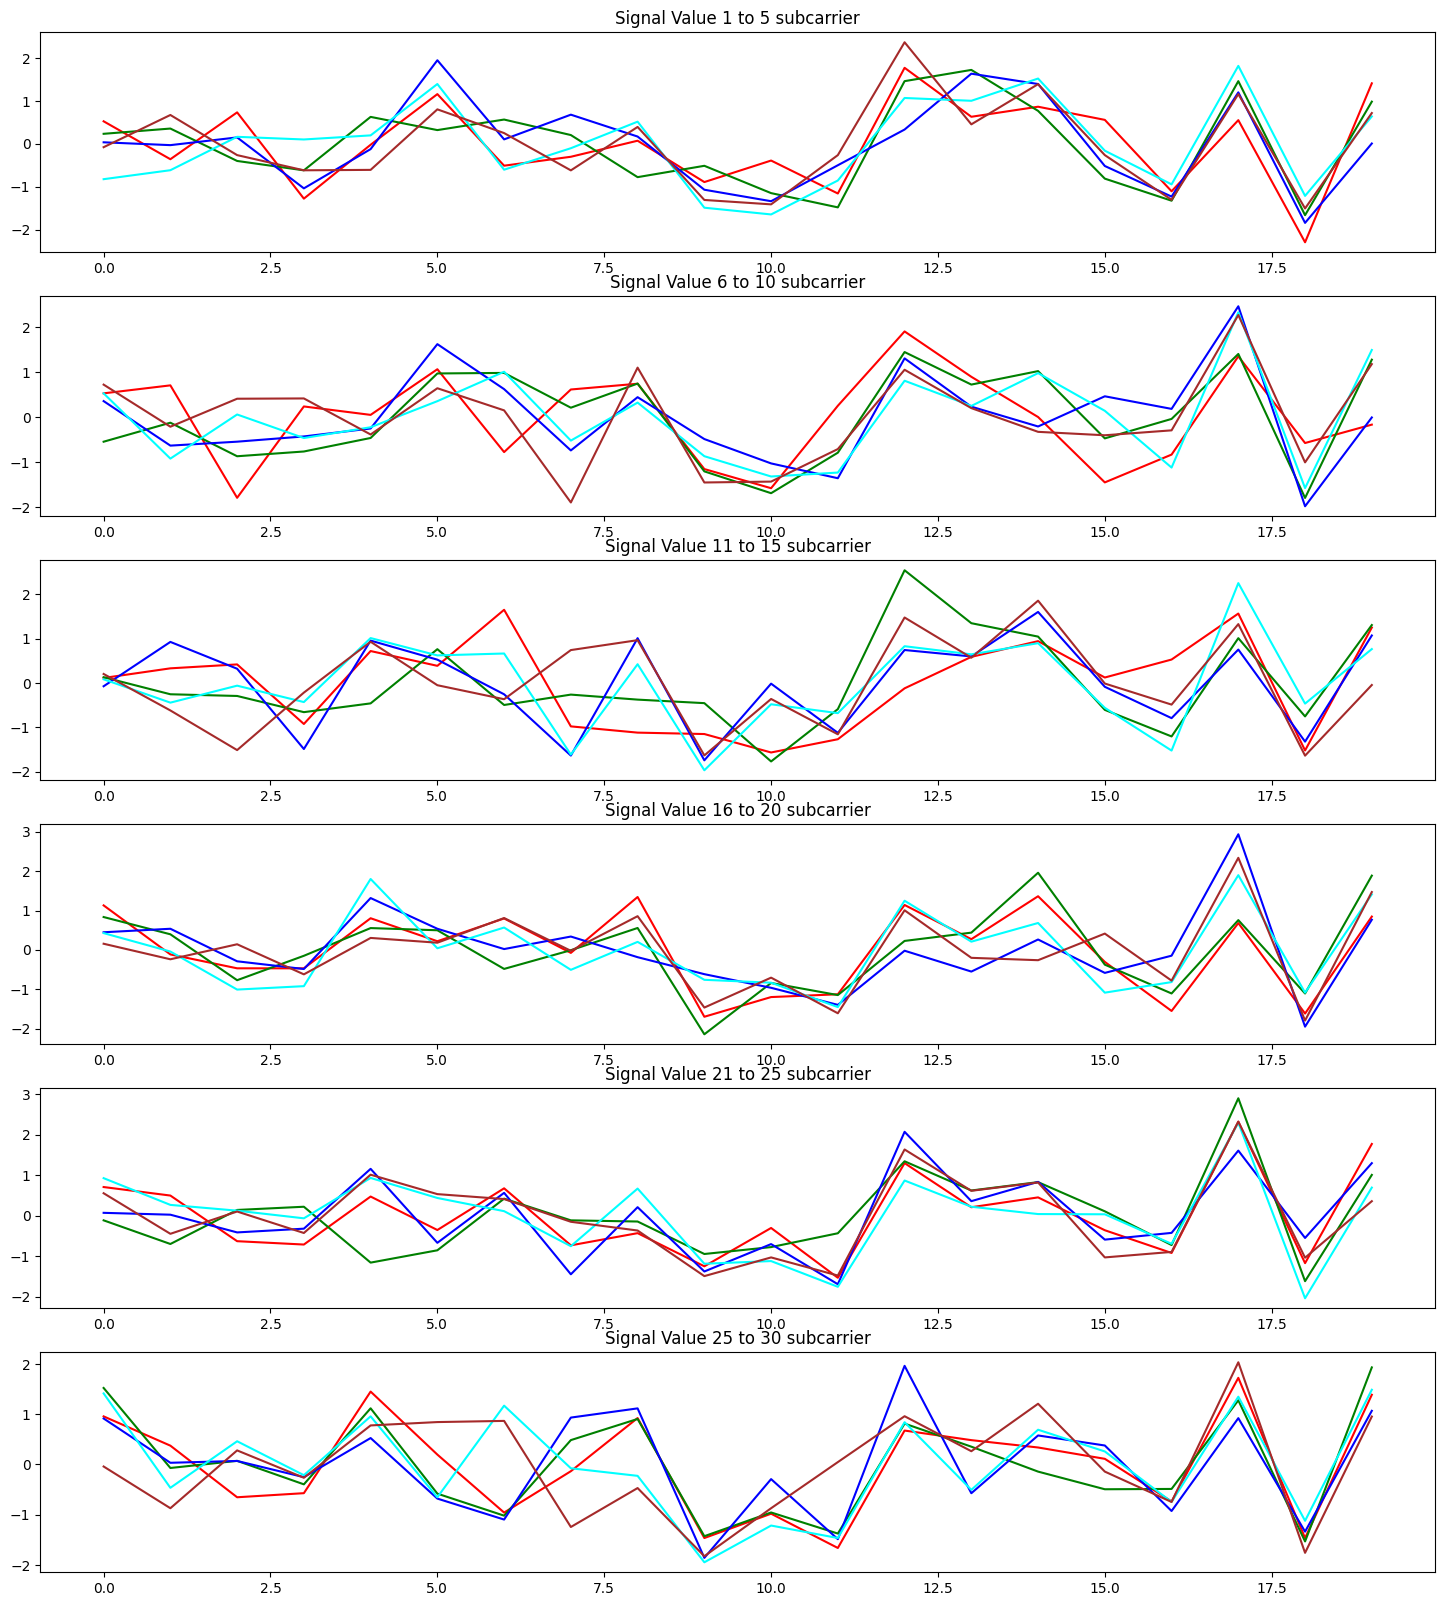

In [162]:
## Plot of amplitude of walking 400:500 i.e 1000 samples technically due to window_size
scaled_jog_fft_amps_df = perform_scaling(jog_fft_amps_final[200:220])
raw_sample_plot(scaled_jog_fft_amps_df)

------

### Data Splitting for Model

In [ ]:
def train_test_split_data(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

### Model Creation

In [ ]:
def train_svm(X_train, y_train):
    """
    Train SVM model using the training data.
    """
    svm = SVC()
    svm.fit(X_train, y_train)
    return svm


def train_knn(X_train, y_train):
    """
    Train KNN model using the training data.
    """
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    return knn
